Oscar Meurer

Guillaume Ferreol

Nicolas Reboullet

# OBJECTIVES:

## General Objectives

Write a Python notebook that will 
1) explain with your own words what information the paper brings with respect to what we studied in class and 
2) illustrate the results of the paper by running some experiments. 

You should design these experiments in order to highlight the pros and the cons of the method proposed in the paper.

## Paper-Related Objectives

- This paper studies a a general family of algorithms known as FTRL (Follow The Regularized Leader), but note that when the regularizer is R(w) = ||w||^2, this is exactly the same as OGA. 
- In class, we calibrated the gradient step in OGA as depending on the Lipschitz constant of the functions to optimize. 
- This paper proposes two methods that does not require to know this constant: AdaFTRL and Solo FTRL. 
- Focus on the second one: Solo FTRL. Describe the method, explain how Theorem 2 improves on the results seen in class. Illustrate this improvement on simulations.


# Scale-Free Algorithms for Online Gradient Descent

https://arxiv.org/abs/1502.05744v2

In this notebook, we will: 

1. Remember the theory about Online Gradient Descent, 
2. Implement the Gradient Descent algorithm with a L-Lipschitz function, 
3. Explain the theory behind SOLO FLTR, what the paper brings, 
4. Implement the algorithm of SOLOT SOLO FLTR, 
5. Compare the performance of SOLO FLTR with the Gradient Descent algorithm.

## Theoretical reminder of Online Optimization Algorithm

The Online Gradient Algorithm (OGA) can be described as follows:

\begin{align*}
& \text{Initialize: } \theta_0 \\
& \text{For } t = 1, 2, \ldots \\
& \quad \text{Receive } x_t \\
& \quad \text{Compute loss } \ell_t = \ell(f(x_t; \theta_{t-1}), y_t) \\
& \quad \text{Compute gradient } g_t = \nabla_{\theta_{t-1}} \ell_t \\
& \quad \text{Update: } \theta_t = \theta_{t-1} - \eta g_t
\end{align*}

where 
1. $\theta_t$ represents the model parameters at time $t$, 
2. $x_t$ is the input data at time $t$, 
3. $f$ is the model function, 
4. $y_t$ is the true label or target at time $t$, 
5. $\ell$ is the loss function, 
6. $g_t$ is the gradient of the loss function with respect to the model parameters, 
7. and $\eta$ is the learning rate.

### Theorem on the regret

![Image Title](theorem_OGA_regret.png)

## Implementation of Online Gradient Descent

In [46]:
import numpy as np
import matplotlib.pyplot as plt

### L-Lipschitz Loss functions

The main purpose of the notebook is to compare a L-Lipschitz, with various constants and the scale free update that is given in the paper 
Let's take this online loss function, where L is an input : 

$$Loss =min(∣y−⟨param,x⟩∣,L)$$

*Nonetheless*, we have to be careful : a too small constant (let's say 0.0001) will result in a loss equal to this constant (0.0001) and thus could be seen as the best model. 

In [47]:
def lipschitz_loss(param, x, y, L):

    """ Returns the loss of a single point regarding y (dim 1) and x (multi dimension point)"""
    
    return min(np.abs(y - np.dot(param, x)), L)

Online Gradient Step 

In [48]:
def OnlineGradient(param, x, y, L):
    """
    Computes the gradient of the Lipschitz continuous loss function with respect to the parameter.

    Parameters:
    param (numpy.ndarray): The current parameter vector.
    x (numpy.ndarray): The input feature vector.
    y (float or numpy.ndarray): The target value(s).
    L (float): The Lipschitz constant.

    Returns:
    numpy.ndarray: The gradient vector of the loss function with respect to the parameter.
    """
    residual = y - np.dot(param, x)
    abs_residual = np.abs(residual)
    sign_res = np.sign(residual)
    
    # Gradient initialization
    grad = np.zeros_like(param)
    
    if abs_residual < L:
        grad = -sign_res * x
    elif abs_residual == L:
        grad = np.zeros_like(param)
    
    return grad

### Preparation: sampling some data

What interests us in this paper is the  Lipschitz constant L that describes the loss function $g_n$ as stated in the theorem 1 of the class. 

We create a polynomial function stored in X. 

$$Y = 1 - \text{design}^2 - \left| \text{design} - 0.5 \right| + \text{noise} \cdot \text{np.random.normal(size=numpoints)}
$$

In [49]:
num_points = 250
noise = 0.1
num_dimensions = 4

#array of n values sampled uniformly from the interval [0, 1] acting as the base for generating features and the target variable.
design = np.random.uniform(low=0, high=1, size=num_points) 

#matrix of shape (num_points, d) where each row represents a data point and each column represents a feature.
X = np.ones(shape=(num_points,num_dimensions)) #first column is initialized to ones (bias term).

for i in range(1,num_dimensions):
    X[:,i] = design**i

Y = 1-design**2-np.abs(design-0.5) + noise*np.random.normal(size=num_points)
Y[100] = 4  ## use this line to test the effect of an outlier

And we can plot it : 

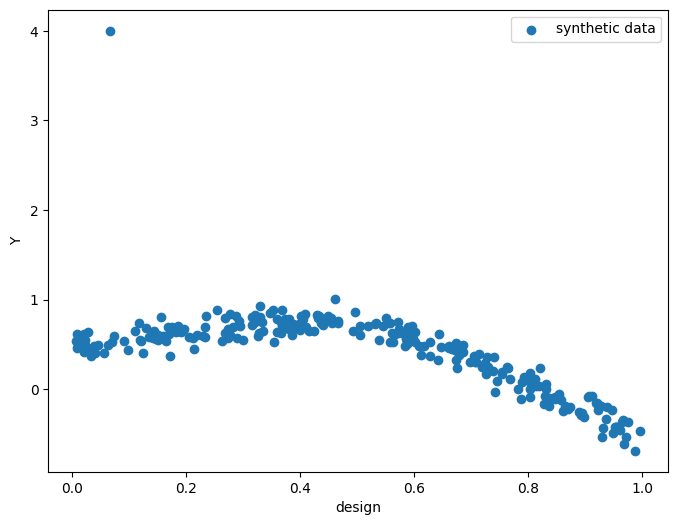

In [50]:
plt.figure(figsize=(8,6))
plt.ylabel("Y")
plt.xlabel("design")
plt.scatter(design, Y, label = "synthetic data")
plt.legend()
plt.show()

### Loss computations with Online Gradient Descent

In [51]:
# Initialize parameters and losses

# List of Lipschitz constants
L_values = [30, 10, 5, 2, 1, 0.5, 0.1, 0.01, 0.001]

params = np.zeros(shape=(len(L_values), num_dimensions))
losses = np.zeros(shape=(len(L_values), num_points))

# Compute losses for each Lipschitz constant
for i in range(num_points):
    for j, L in enumerate(L_values):
        losses[j, i] = lipschitz_loss(params[j], X[i], Y[i], L)
        params[j] = params[j] - OnlineGradient(params[j], X[i], Y[i], L) / np.sqrt(i + 1)

### Plot of the final estimates

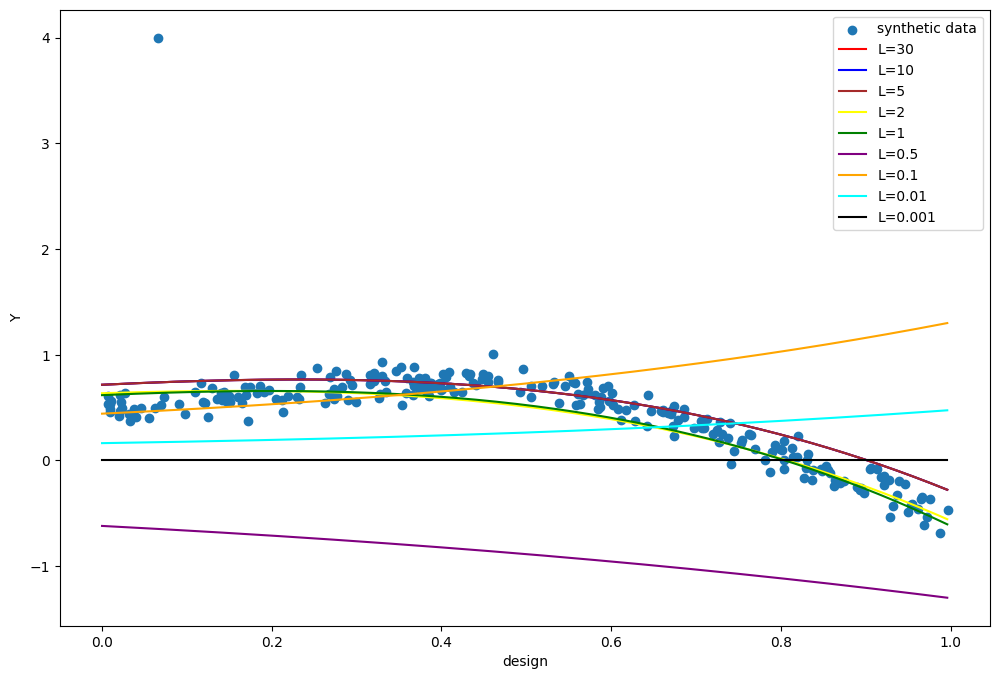

In [52]:
grid = np.arange(0,1,1/num_points)
Xgrid = np.ones(shape=(num_points,num_dimensions))
for i in range(1,num_dimensions):
    Xgrid[:,i] = grid**i

colors = ["red", "blue", "brown", "yellow", "green", "purple", "orange", "cyan", "black"]
plt.figure(figsize=(12, 8))
plt.ylabel("Y")
plt.xlabel("design")
plt.scatter(design, Y, label = "synthetic data")
for j, L in enumerate(L_values):
    plt.plot(grid, params[j] @ Xgrid.T,color=colors[j], label=f'L={L}')
plt.legend()

We can see that we have some of the curves that we can eliminate : the last 4 ones have a too small constant resulting in a non credible loss. 

### Plot the cumulated errors for each Lipschitz constant

Text(0.5, 1.0, 'Cumulated Errors for Each Lipschitz Constant')

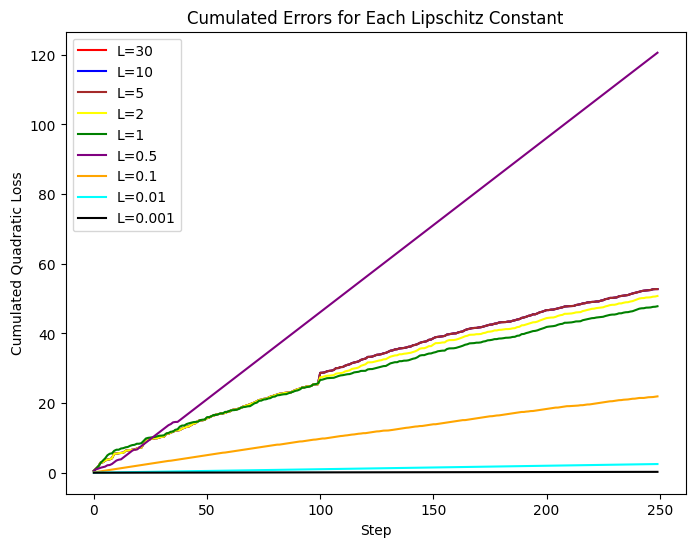

In [53]:
plt.figure(figsize=(8, 6))
plt.ylabel("Cumulated Quadratic Loss")
plt.xlabel("Step")
for j, L in enumerate(L_values):
    plt.plot(np.cumsum(losses[j]), color=colors[j], label=f'L={L}')
plt.legend()
plt.title('Cumulated Errors for Each Lipschitz Constant')


Obviously, the cumulated quadratic losses related to 0.001, 0.01, 0.1 cannot be taken into account : they just sum [0.001, 0.001, 0.001, 0.001...] for example. 

### Plot the online mean error

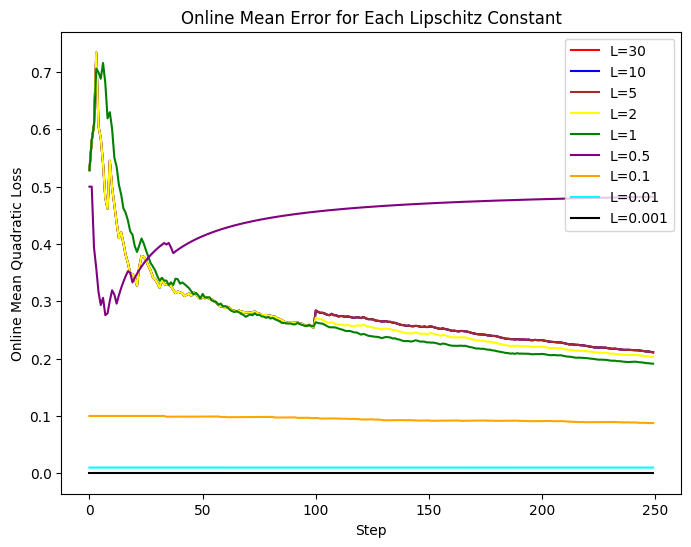

In [57]:
plt.figure(figsize=(8, 6))
plt.ylabel("Online Mean Quadratic Loss")
plt.xlabel("Step")
for j, L in enumerate(L_values):
    NN = np.arange(1, num_points + 1)
    plt.plot(np.cumsum(losses[j]) / NN, color=colors[j], label=f'L={L}')
plt.title('Online Mean Error for Each Lipschitz Constant')
plt.legend()

Thus, in line with the previous graph, the best constant is 1 here. 

## Explanation of what the paper brings

SOLO FTRL (Scale-free Online Linear Optimization Follow The Regularized Leader) is a method designed to optimize online linear decision processes **without needing advance knowledge of the loss vector norms** or **the Lipschitz constants of the functions being optimized**. 

The regularizer used in SOLO FTRL is of the form $R(w)$, where $R(w)$ is **any strongly convex function**. This choice allows the method to **adapt its learning rate based on the observed data dynamically**, rather than relying on preset parameters. 

The specifics of how the learning rate adapts depend on the cumulative norms of the gradient seen thus far, aligning with the philosophy of adjusting the learning rate based on the scale of incoming data rather than preset estimates.


### Algorithm

The update rule in SOLO FTRL is as follows: 
1. Initialize $𝐿_0 =0$ 
2. For each round $t$: 
- Compute $w_t$ ​ by solving the optimization problem: $w_t = \arg\min_{w \in K} \left( \langle L_{t-1}, w \rangle + R_t(w) \right)$
- Observe the loss vector $L_t$ ​ . 
- Update the cumulative loss $L_t ​ =L_{t−1} ​ + L_t$

Here, $R(w)$ is a regularizer that changes over time, making the algorithm adaptive. The key feature of SOLO FTRL is its scale-free property, meaning it performs consistently regardless of the scaling of the loss vectors.

## SOLO FLTR Class implementation

Here, we can create a class so that we can create various instance of our optimizer. 

In [ ]:
class SOLOFTRL:
    def __init__(self, regularizer_func):
        self.L = None
        self.regularizer_func = regularizer_func

    def initialize(self, dim):
        self.L = np.zeros(dim)

    def update(self, loss_vector):
        if self.L is None:
            raise ValueError("Initialize the algorithm first using `initialize` method.")
        def objective(w):
            return np.dot(self.L, w) + self.regularizer_func(w)
        # Assuming a simple quadratic regularizer for demonstration purposes:
        from scipy.optimize import minimize
        result = minimize(objective, np.zeros_like(self.L))
        w_t = result.x
        self.L += loss_vector
        return w_t

In [58]:


# Example usage:
def quadratic_regularizer(w):
    return 0.5 * np.dot(w, w)

solo_ftrl = SOLOFTRL(regularizer_func=quadratic_regularizer)
solo_ftrl.initialize(dim=10)
for t in range(1, 101):
    loss_vector = np.random.randn(10)  # Replace with actual loss vector
    w_t = solo_ftrl.update(loss_vector)
    print(f"Round {t}, weights: {w_t}")


Round 1, weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Round 2, weights: [-0.91330676 -0.49583994 -1.10499528 -0.31537544  0.44114846 -0.66125494
  2.50973059  1.03533945 -1.33246498  0.58288288]
Round 3, weights: [-0.78143311 -2.42224318 -0.27228499  0.73234218  2.88896799 -0.47056209
  0.75777954  0.20052564 -0.85409591  1.48977   ]
Round 4, weights: [-1.67956189 -2.58526025 -0.81746921  0.83041579  2.53093659 -0.36421734
  0.07488461  0.982123   -0.51383935  1.44699015]
Round 5, weights: [ 0.76910437 -2.01503982  1.61993002  0.62759604  3.22502173 -1.35962072
 -0.68816718  1.43855202 -0.75464091  1.79633556]
Round 6, weights: [-1.06203656 -2.50277018 -0.04849998 -1.59188267  1.29608755 -1.67191673
 -0.45773893 -0.36585419 -0.18444312  2.63084885]
Round 7, weights: [-0.17919869 -3.79523336  0.40884562 -2.77490814  2.57816378  0.29848085
  0.57464854  0.41711819 -1.39934357  1.6799363 ]
Round 8, weights: [-0.21917718 -4.60135857  2.80367398 -3.03143803  1.41669662  1.25611538
 -0.06141877 